In [1]:

import os 
import tensorflow as tf 
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 , preprocess_input
from tensorflow.keras.layers import Dense , Conv2D , GlobalAvgPool2D , Input
from tensorflow.keras.preprocessing.image import load_img , ImageDataGenerator
from tensorflow.keras import optimizers , callbacks
import numpy as np
import cv2
import numpy as np
from google.colab import drive 

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!unzip animals10.zip

### the class names are in italian so we need to translate them

In [ ]:
!pip install googletrans==3.1.0a0
from googletrans import Translator

In [ ]:
translator = Translator()

classes_dict = {}
for i in os.listdir('raw-img'):
  classes_dict[i] = translator.translate(i , src='it',dist = 'en').text



## changing the folders names in directory

In [ ]:
for i in os.listdir('raw-img'):
  try:
    os.rename('raw-img/'+i  , 'raw-img/'+classes_dict[i])
  except Exception as e:
    print(e)

In [ ]:
!ls raw-img/

ls: cannot access 'raw-img/': No such file or directory


In [ ]:
for i in os.listdir('/content/drive/MyDrive/MyShares/animal10/raw-img'):
  print(i , len(os.listdir('/content/drive/MyDrive/MyShares/animal10/raw-img/'+i)))

horse 1223
sheep 420
dog 3463
elephant 46
butterfly 712
chicken 1698
cat 268
cow 466
spider 3421
squirrel 462


In [ ]:
try:
  os.mkdir('train')
  os.mkdir('test')
except:
  pass

for i in os.listdir('raw-img'):
  try:
    os.mkdir('train/' + i)
    os.mkdir('test/' + i)
  except:
    pass
  for j in os.listdir('raw-img/' + i)[:1000]:
    os.rename('raw-img/' + i + '/' + j , 'train/' + i + '/' + j)
  for j in os.listdir('raw-img/' + i)[:400]:
    os.rename('raw-img/' + i + '/' + j , 'test/' + i + '/' + j)


In [ ]:
! ls test

In [3]:
def image_data_generator(dir_path , targetsize , batch_size ,class_lst , preprocessing):
  if preprocessing:
    gen_obj = ImageDataGenerator(preprocessing_function=preprocessing)
  else:
    gen_obj = ImageDataGenerator()

  generator = gen_obj.flow_from_directory(dir_path , target_size = targetsize ,
                                          batch_size = batch_size ,
                                          class_mode = 'sparse',
                                          classes = class_lst,
                                          shuffle = True)
  return generator

In [4]:
train_data_gen = image_data_generator('/content/drive/MyDrive/MyShares/animal10/train' 
                                      , (224 , 224) , 500 , 
                                      os.listdir('/content/drive/MyDrive/MyShares/animal10/train') 
                                      , preprocess_input)
valid_data_gen = image_data_generator('/content/drive/MyDrive/MyShares/animal10/test' ,
                                      (224 , 224) , 500 ,
                                      os.listdir('/content/drive/MyDrive/MyShares/animal10/test') 
                                      , preprocess_input)

Found 10000 images belonging to 10 classes.
Found 4000 images belonging to 10 classes.


In [5]:
classes = train_data_gen.class_indices
classes_list = {value : key for key , value in classes.items()}
print(classes_list)

{0: 'dog', 1: 'horse', 2: 'elephant', 3: 'butterfly', 4: 'chicken', 5: 'cat', 6: 'cow', 7: 'sheep', 8: 'spider', 9: 'squirrel'}


In [11]:
mob_net_model = tf.keras.applications.MobileNetV2(
    input_shape=(224 , 224 , 3), alpha=1.0, include_top=False, weights='imagenet',
    input_tensor=None, pooling=None, classes=1000,
    classifier_activation='softmax'
)

In [12]:
mob_net_model.trainable = False

In [13]:
model = tf.keras.Sequential()
model.add(mob_net_model)
model.add(GlobalAvgPool2D())
model.add(Dense(1024 , activation = 'relu'))
model.add(Dense(10 , activation = 'softmax'))

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
dense_3 (Dense)              (None, 10)                10250     
Total params: 3,579,978
Trainable params: 1,321,994
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(optimizer = 'adam' , loss = 'sparse_categorical_crossentropy' ,
              metrics = ['accuracy'])

In [ ]:
early_stop = callbacks.EarlyStopping(monitor='val_loss' , patience=5 , mode='min')
check_point = callbacks.ModelCheckpoint('/content/drive/MyDrive/MyShares/animal10/animals_model_w.h5', 
                                        save_best_only=True ,
                                        monitor='val_loss' , mode='min')

class Mycallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self , epochs , logs = {}):
    if (logs.get('accuracy')>=0.98):
      model.stop_training = True

acc_reached = Mycallback()

In [ ]:
history = model.fit(train_data_gen , validation_data=valid_data_gen , 
                    epochs=20 , callbacks=[early_stop , check_point , acc_reached] , 
                    batch_size=500)

Epoch 1/20
20/20 [==============================] - 65s 3s/step - loss: 0.7980 - accuracy: 0.7396 - val_loss: 0.2025 - val_accuracy: 0.9442
Epoch 2/20
20/20 [==============================] - 57s 3s/step - loss: 0.1373 - accuracy: 0.9613 - val_loss: 0.1776 - val_accuracy: 0.9520
Epoch 3/20
20/20 [==============================] - 57s 3s/step - loss: 0.0890 - accuracy: 0.9761 - val_loss: 0.1856 - val_accuracy: 0.9480
Epoch 4/20
20/20 [==============================] - 57s 3s/step - loss: 0.0557 - accuracy: 0.9846 - val_loss: 0.1864 - val_accuracy: 0.9530


In [15]:

model.load_weights('/content/drive/MyDrive/MyShares/animal10/animals_model_w.h5')

actual class is  dog.jpg
predicted class is  dog


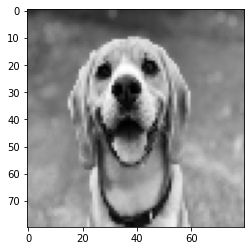


actual class is  dog2.jpg
predicted class is  dog


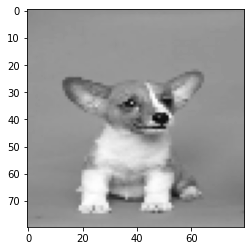


actual class is  spider.jpg
predicted class is  spider


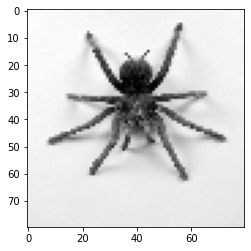


actual class is  spider1.jpg
predicted class is  spider


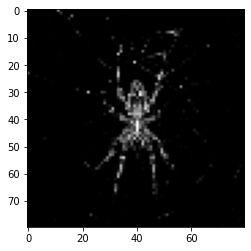


actual class is  chicken.jpg
predicted class is  chicken


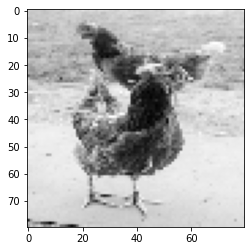


actual class is  elephant.jpg
predicted class is  elephant


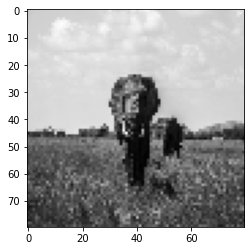


actual class is  horse.jpg
predicted class is  horse


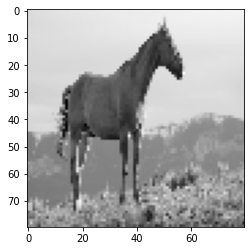


actual class is  squrl.jpg
predicted class is  squirrel


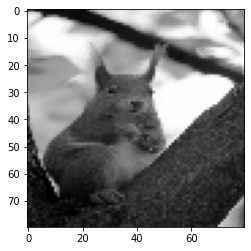


actual class is  cat.jpg
predicted class is  cat


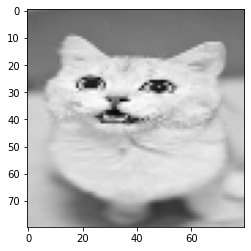


actual class is  cat2.jpg
predicted class is  cat


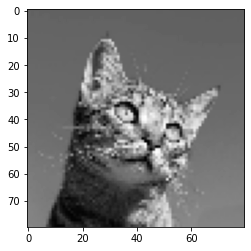


actual class is  batterfly.jpg
predicted class is  butterfly


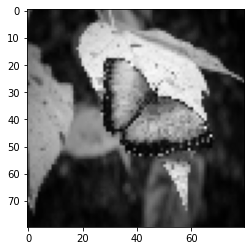


actual class is  sheep.jpg
predicted class is  sheep


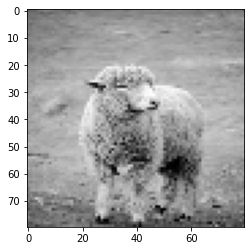

In [26]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt


def prepare_for_pred(filepath):
  image = load_img(filepath , target_size=(224,224))
  img_to_arr = img_to_array(image)
  img_arr = img_to_arr/255.
  img_arr=np.expand_dims(img_arr,axis=0)
  return img_arr


test_path  = '/content/drive/MyDrive/MyShares/animal10/test real photo'
for image in os.listdir(test_path):
  pred = model.predict(prepare_for_pred(os.path.join(test_path , image)))
  pred = np.argmax(pred , axis = 1)
  print('actual class is ' , image)
  print('predicted class is ', classes_list[pred[0]])
  image_array = cv2.imread(os.path.join(test_path , image) , cv2.IMREAD_GRAYSCALE)
  new_array = cv2.resize(image_array , (80 , 80))
  plt.imshow(new_array , cmap = 'gray')
  plt.show()
  print()
